In [1]:
from common.np import *

# Chapter 5. RNN

## \# 5.3.1 RNN 계층 구현

- 이 책에서는 단일 RNN 단위를 `RNN`으로, 각 RNN이 서로의 출력값을 다시 순환하면서 받는 T개의 RNN을 `Time RNN`으로 명명

### (1) 단일 RNN 클래스 구현
- 단일 RNN 클래스는 시계열 데이터인 `x_t`를 처리하는 가중치 `Wx`와, 이전 층의 출력값인 `h_t`를 처리하는 가중치 `W_h` 두 가지를 가짐


- $h_t = tanh(h_{t-1} W_h + x_t W_x + b)$ 의 식으로 `forward` 연산 처리

In [2]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    
    
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)
        
        self.cache = (x, h_prev, h_next)
        return h_next
    
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dWx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev

### (2) 단일 RNN이 모여있는 `Time RNN` 구현
- `RNN`이 `T`개 모아서 한 계층인 `Time RNN`을 구현


- `Time RNN`이라는 표현은 이 책의 독립적인 명명법임


- `Time RNN`은 `stateful`이라는 변수를 가짐
    - `stateful` : 이전 블록의 출력인 `h`를 저장할지 말지에 대한 참값 (stateful의 뜻: '상태가 있는')
    - 즉, 이 값이 True이면 시계열 데이터가 아무리 길더라도 순전파를 끊지 않고 전파

In [3]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.dh = None, None
        self.stateful = stateful
        
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        # stateful=False이면 self.h를 영행렬로 저장
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs
    
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx
            
            # 가중치는 모든 단일 RNN의 가중치를 모두 더한 것
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs
    
    
    def set_state(self, h):
        self.h = h
    
    
    def reset_state(self):
        self.h = None

---
## \# 5.4.2 RNNLM 모델 - Time 계층 구현

- RNN 언어 모델의 전체 구조인 `Time Embedding`, `Time RNN`, `Time Affine`, `Time Softmax` 를 모두 구현

### (1) `Time Embedding` 계층

In [4]:
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W
        
    
    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape
        
        out = np.empty((N, T, D), dtype='f')
        self.layers = []
        
        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)
        return out
    
    
    def backward(self, dout):
        N, T, D = dout.shape
        
        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]
            
        self.grads[0][...] = grad
        return None

### (2) `Time Affine` 계층
- `TimeAffine`은 행렬 계산으로 효율적으로 처리하기 위해 `reshape` 해서 연산

In [5]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None
        
    
    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params
        
        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)
    
    
    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params
        
        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)
        
        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)
        
        self.grads[0][...] = dW
        self.grads[1][...] = db
        
        return dx

### (3) `Time Softmax With Loss` 계층

In [6]:
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1
        
    
    def forward(self, xs, ts):
        N, T, V = xs.shape
        
        if ts.ndim == 3:
            ts = ts.argmax(axis=2)
            
        # ignore_label이 -1 인 것들을 마스킹 (ignore_label 위치에는 0으로 저장됨)
        mask = (ts != self.ignore_label)
        
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)
        
        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask # ignore_label 위치는 loss를 0으로 계산
        loss = -np.sum(ls)
        loss /= mask.sum()
        
        self.cache = (ts, ys, mask, (N, T, V))
        return loss
    
    
    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache
        
        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]
        
        dx = dx.reshape((N, T, V))
        return dx

---
## \# 5.5.1 `SimpleRnnlm` 구현

In [7]:
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화 : Xavier 초깃값 
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        # 모든 가중치와 기울기 모으기
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    
    def reset_state(self):
        self.rnn_layer.reset_state()

---
## \# 5.5.2 언어 모델의 평가 - `SimpleRnnlm` 평가하기

- 혼잡도(perplexity)를 이용해서 평가


- perplexity란, 확률의 역수 값으로 잘 예측(확률이 높음)할 수록 값이 낮고, 잘 못 예측(확률이 낮음)할 수록 값이 높다
- 즉, perplexity는 낮을수록 덜 혼잡하므로, 더 좋은 예측을 한다고 할 수 있음


- 여기서, perplexity 값은 '분기수'(number of branches) 라고 생각할 수 있다. 
- 즉, `perplexity = 1.25`면 예측하는 단어 수가 약 1.25개 정도인데, `perplexity = 5`면 예측하는 단어 수가 5개나 된다는 의미.
- 확률값이 1이면 perplexity도 1이므로, 단 하나의 단어로 좁혀졌다는 뜻으로 볼 수 있음. 


- 데이터가 여러 개일때는, $perplexity = e^L$ (L은 손실함수값) 으로 둘 수 있음 (교차엔트로피오차 사용)

---
## \# 5.5.3 RNNLM의 학습코드

- SimpleRnnlm은 PTB 데이터셋 전체를 학습할 수 없으므로, 첫 1000단어만 활용

In [8]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from common.dataset import PTB
from common.layer import Embedding
from common.function import softmax

#### 1. 하이퍼파라미터 설정

In [9]:
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5 # Truncated BPTT 블록 안의 RNN 개수
lr = 0.1
max_epoch = 100
log_step = 10

#### 2. 학습 데이터 가져오기 (첫 1000단어만)

In [10]:
ptb = PTB()
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

#### 3. 입력데이터: 첫 999단어 / 정답데이터: 첫단어 빼고 999단어

In [11]:
xs = corpus[:-1]
ts = corpus[1:]

In [12]:
data_size = len(xs)
print("corpus size: %d, vocab size: %d" % (corpus_size, vocab_size))

corpus size: 1000, vocab size: 418


#### 4. 학습에 사용되는 변수

In [13]:
max_iters = data_size // (batch_size * time_size)
time_idx = 0    # time_idx는 한 블록 안에서 몇 번째인지 나타내는 idx (offset + time_idx)
total_loss = 0
loss_count = 0
ppl_list = []

#### 5. 모델 생성

In [14]:
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

#### 6. 각 미니배치에서 샘플을 읽을 위치를 계산 (offset)
- offset은 데이터를 읽을 시작 위치로 볼 수 있음

In [15]:
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

#### 6. 학습 시작

In [16]:
for epoch in range(max_epoch):
    for iter in range(max_iters):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
            
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        
    avg_loss = total_loss / loss_count
    ppl = np.exp(avg_loss)
    if (epoch) % log_step == 0:
        print("epoch %d | ppl : %.2f " % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

epoch 1 | ppl : 403.15 
epoch 11 | ppl : 188.91 
epoch 21 | ppl : 181.32 
epoch 31 | ppl : 156.67 
epoch 41 | ppl : 115.89 
epoch 51 | ppl : 71.71 
epoch 61 | ppl : 40.75 
epoch 71 | ppl : 22.93 
epoch 81 | ppl : 13.65 
epoch 91 | ppl : 7.52 


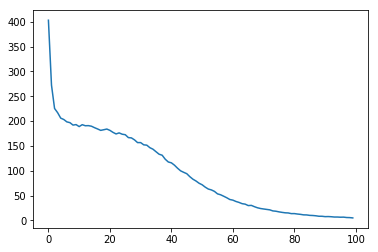

In [18]:
plt.plot(ppl_list)
plt.show()